# Importación de Librerías

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
## Metricas
from sklearn import metrics
## Modelado
from sklearn import linear_model


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def scores_models(y_real , y_predicted):
    MSE = metrics.mean_squared_error(y_real, y_predicted)
    RMSE = np.sqrt( metrics.mean_squared_error(y_real, y_predicted) )
    MAPE = metrics.mean_absolute_percentage_error(y_real,y_predicted)
    R2score = metrics.r2_score(y_true=y_real,y_pred=y_predicted)

    print(f'Score MSE  : {MSE:0.5f}')
    print(f'Score RMSE : {RMSE:0.5f}')
    print(f'Score MAPE : {MAPE:0.5f}')
    print(f'R^2-score  : {R2score:0.5}')

In [ ]:
#dfLF = pd.read_excel("./DB_Modelado--2.xlsx")
dfLF = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/DB_Modelado--2.xlsx")

Eliminamos las variables coordenadas porque es una variable no necesaria ya que para la ubicación del inmueble tenemos las variables de los barrios, y además posee mucha variablidad que puede molestar a la hora de construir un modelo.

In [ ]:
dfLF = dfLF.drop(['idPost','coordenadas.lat','coordenadas.lng','coordenadas','en_cordoba'], axis=1)

In [ ]:
print("Columnas disponibles para modelado (",len(dfLF.columns),"): \n ", dfLF.columns)

Columnas disponibles para modelado ( 43 ): 
  Index(['Precio', 'm2total', 'm2cubierto', 'Banos', 'Dormitorios', 'Ambientes',
       'Antiguedad', 'Cochera', 'Toilette', 'Villa Belgrano', 'Argüello',
       'Cerro de las Rosas', 'URCA', 'Valle Escondido', 'Alta Córdoba',
       'Jardín', 'Alto Alberdi', 'Manantiales', 'Villa Rivera Indarte',
       'Greenville II', 'Villa Warcalde', 'Colón', 'Lomas de la Carolina',
       'Centro', 'country', 'living', 'duplex', 'quincho', 'escritura',
       'quinta', 'terraza', 'escritorio', 'lavadero', 'asador', 'galeria',
       'balcon', 'demoler', 'reciclar', 'barrio cerrado', 'oportunidad',
       'pileta_piscina', 'patio_jardin', 'plantaalta_pa'],
      dtype='object')


# Modelos

<FONT COLOR="red">Nota:</FONT> Los Códigos de cada sección están pensados para poder ser ejecutados individualmente si se desea, por ellos se incurre en redundancia de código

## Regresión Lineal Multivariable OLS

In [ ]:
# Divide las variables independientes (X) y la variable dependiente (y)
X = dfLF.drop(['Precio'], axis=1)
y = dfLF['Precio']

In [ ]:
# División de datos en conjunto de entrenamiento y conjunto de prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(5564, 42) (1392, 42) (5564,) (1392,)


In [ ]:
#CODIGOS PARA EXPORTAR BASES DE ENTRENAMIENTO Y TEST
#X_train.to_excel("/content/drive/MyDrive/X_trainV1.xlsx", index=False)
#y_train.to_excel("/content/drive/MyDrive/y_trainV1.xlsx", index=False)
#X_test.to_excel("/content/drive/MyDrive/X_testV1.xlsx", index=False)
#y_test.to_excel("/content/drive/MyDrive/t_testV1.xlsx", index=False)

In [ ]:
# Buscamos la variable más significativa para inicializar el procedimiento de Forward Selection
significancia_por_variable = []
for predictor in X_train.columns:
    X_temp = X_train[predictor]
    X_temp = sm.add_constant(X_temp)  # Agrega el término constante
    model = sm.OLS(y_train, X_temp).fit()
    p_value = model.pvalues[predictor]  # Obtiene el valor de significancia de la variable predictora
    significancia_por_variable.append((predictor, p_value))
significancia_por_variable.sort(key=lambda x: x[1])
print("Variable más significativa:", significancia_por_variable[0][0])

Variable más significativa: m2cubierto


In [ ]:
#Función que Implementa Fordward Selection
def forward_selection_olstest(X_train, X_test, y_train, y_test, variables_disponibles):
    selected_variables = {"m2cubierto"}  # Comienza con "m2cubierto" en la selección inicial
    r2_scores_train = []
    r2_scores_test = []
    mape_scores_train = []
    mape_scores_test = []

    resultsOLS = {'Variables Seleccionadas': [],
               'R^2 Ajustado (Train)': [],
               'R^2 Ajustado (Test)': [],
               'MAPE (Train)': [],
               'MAPE (Test)': [],
               'MSE (Train)': [],
               'MSE (Test)': []}
    k=0
    while variables_disponibles:
        k=k+1
        best_r2_test = -np.inf
        best_variable = None

        for variable in variables_disponibles:
            variables_temp = list(selected_variables) + [variable]
            X_train_temp = X_train[variables_temp]
            X_test_temp = X_test[variables_temp]

            model = sm.OLS(y_train, sm.add_constant(X_train_temp)).fit()
            y_pred_train = model.predict(sm.add_constant(X_train_temp))
            y_pred_test = model.predict(sm.add_constant(X_test_temp))

            r2_train = r2_score(y_train, y_pred_train)
            r2_test = r2_score(y_test, y_pred_test)

            mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
            mape_test = mean_absolute_percentage_error(y_test, y_pred_test)

            if r2_test > best_r2_test:
                best_r2_test = r2_test
                best_variable = variable

        if best_variable is not None:
            print(f"--------PASO {k}----------")
            print(f"Variable agregada: {best_variable}")
            print(f"R^2 ajustado en train: {r2_train}")
            print(f"R^2 ajustado en test: {best_r2_test}")
            print(f"MAPE en train: {mape_train}")
            print(f"MAPE en test: {mape_test}\n")

            selected_variables.add(best_variable)
            variables_disponibles.remove(best_variable)
            r2_scores_train.append(r2_train)
            r2_scores_test.append(best_r2_test)
            mape_scores_train.append(mape_train)
            mape_scores_test.append(mape_test)

            X_train_temp = X_train[selected_variables]
            X_test_temp = X_test[selected_variables]
            model = sm.OLS(y_train, sm.add_constant(X_train_temp)).fit()
            y_pred_train = model.predict(sm.add_constant(X_train_temp))
            y_pred_test = model.predict(sm.add_constant(X_test_temp))

            r2_train = r2_score(y_train, y_pred_train)
            r2_test = r2_score(y_test, y_pred_test)
            MSEtr = mean_squared_error(y_train, y_pred_train)
            MSEte = mean_squared_error(y_test, y_pred_test)

            # Agregar los resultados a la tabla
            resultsOLS['Variables Seleccionadas'].append(selected_variables.copy())
            resultsOLS['R^2 Ajustado (Train)'].append(r2_train)
            resultsOLS['R^2 Ajustado (Test)'].append(r2_test)
            resultsOLS['MAPE (Train)'].append(mape_train)
            resultsOLS['MAPE (Test)'].append(mape_test)
            resultsOLS['MSE (Train)'].append(MSEtr)
            resultsOLS['MSE (Test)'].append(MSEte)

    resultsOLS_df = pd.DataFrame(resultsOLS)
    return selected_variables, r2_scores_train, r2_scores_test, mape_scores_train, mape_scores_test, resultsOLS_df

In [ ]:
# Aplicacion forward de regresion multiples
variables_disp = set(X_train.columns.tolist())
variables_disp.remove("m2cubierto")

selected_vars, r2_train, r2_test, mape_train, mape_test, resultsOLS_df = forward_selection_olstest(X_train=X_train,
                      X_test=X_test,
                      y_train=y_train,
                      y_test=y_test,
                      variables_disponibles=variables_disp)

--------PASO 1----------
Variable agregada: country
R^2 ajustado en train: 0.6299865961447615
R^2 ajustado en test: 0.5786017306774515
MAPE en train: 0.4601385185557845
MAPE en test: 0.4719666860168604

--------PASO 2----------
Variable agregada: Antiguedad
R^2 ajustado en train: 0.6586271383735209
R^2 ajustado en test: 0.5966907916380814
MAPE en train: 0.4480521408930105
MAPE en test: 0.45650708933799156

--------PASO 3----------
Variable agregada: Lomas de la Carolina
R^2 ajustado en train: 0.674784057248881
R^2 ajustado en test: 0.6137328099766963
MAPE en train: 0.4078178952596175
MAPE en test: 0.4176002199298925

--------PASO 4----------
Variable agregada: Valle Escondido
R^2 ajustado en train: 0.6855265405214805
R^2 ajustado en test: 0.6181933411034128
MAPE en train: 0.403281439058227
MAPE en test: 0.4135907292067193

--------PASO 5----------
Variable agregada: m2total
R^2 ajustado en train: 0.6871365547814299
R^2 ajustado en test: 0.6223761219446847
MAPE en train: 0.3997079380841

In [ ]:
resultsOLS_df

,Variables Seleccionadas,R^2 Ajustado (Train),R^2 Ajustado (Test),MAPE (Train),MAPE (Test),MSE (Train),MSE (Test)
0,"{m2cubierto, country}",0.658337,0.578602,0.460139,0.471967,1.141306e+10,1.266376e+10
1,"{Antiguedad, m2cubierto, country}",0.674784,0.596691,0.448052,0.456507,1.086367e+10,1.212016e+10
2,"{Lomas de la Carolina, Antiguedad, m2cubierto,...",0.685526,0.613733,0.407818,0.417600,1.050483e+10,1.160801e+10
3,"{m2cubierto, country, Lomas de la Carolina, An...",0.687136,0.618193,0.403281,0.413591,1.045104e+10,1.147397e+10
4,"{m2cubierto, m2total, country, Lomas de la Car...",0.690521,0.622376,0.399708,0.409579,1.033797e+10,1.134827e+10
5,"{m2cubierto, m2total, country, Lomas de la Car...",0.708186,0.626106,0.396221,0.406386,9.747910e+09,1.123618e+10
6,"{country, m2total, Lomas de la Carolina, Antig...",0.710922,0.629336,0.384519,0.386136,9.656510e+09,1.113912e+10
7,"{country, m2total, Lomas de la Carolina, Antig...",0.712092,0.631747,0.380171,0.385830,9.617407e+09,1.106665e+10
8,"{country, m2total, Lomas de la Carolina, Antig...",0.718343,0.634565,0.377555,0.379758,9.408605e+09,1.098196e+10
9,"{country, m2total, Lomas de la Carolina, Antig...",0.719946,0.636246,0.381218,0.384061,9.355069e+09,1.093145e+10


In [ ]:
############### PLOTS ###########################
variable_agregadas_lin=[]
for i in range(len(resultsOLS_df["Variables Seleccionadas"].values)-1):
    #print(i)
    variable_agregada_set=resultsOLS_df["Variables Seleccionadas"].values[i+1] - resultsOLS_df["Variables Seleccionadas"].values[i]
    #print(variable_agregada_set)
    variable_agregadas_lin.append(list(variable_agregada_set)[0])

variable_agregadas_lin.insert(0,"country & m2cubierto")
len(variable_agregadas_lin)

41

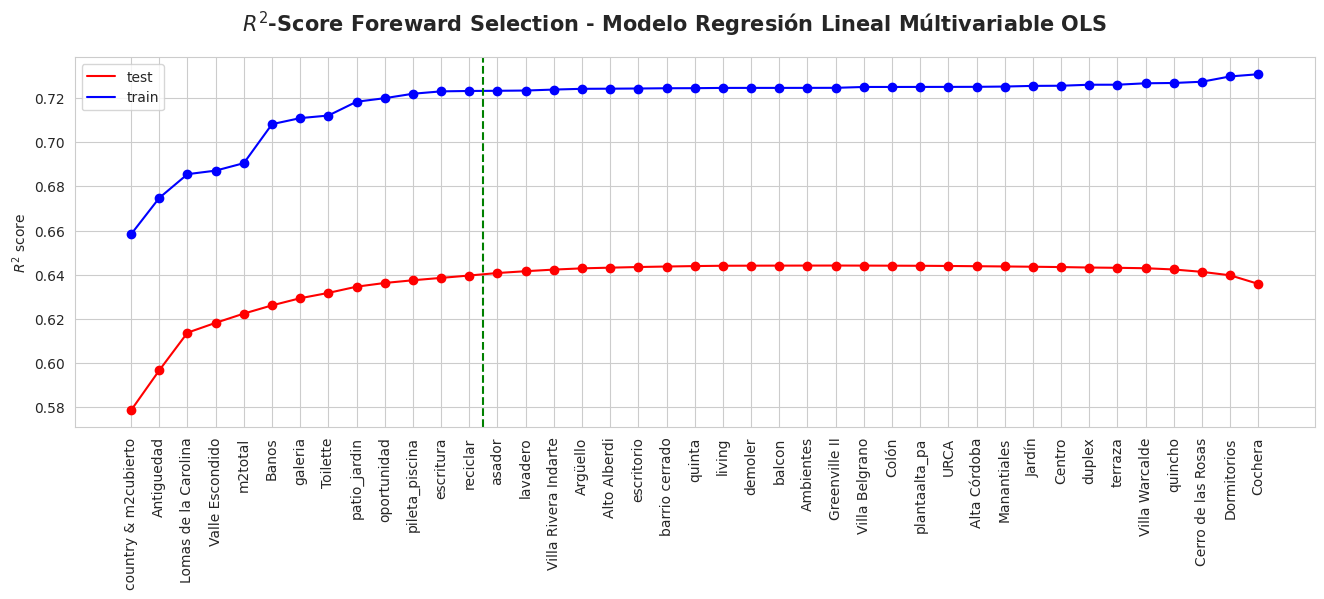

In [ ]:
x_plot=variable_agregadas_lin
y_plot_train=resultsOLS_df["R^2 Ajustado (Train)"].values
y_plot_test=resultsOLS_df["R^2 Ajustado (Test)"].values
fig,ax = plt.subplots()
ax.plot(x_plot,y_plot_test,color="red",label="test")
ax.scatter(x_plot,y_plot_test,color="red")
ax.plot(x_plot,y_plot_train,color="blue",label="train")
ax.scatter(x_plot,y_plot_train,color="blue")
ax.set_ylabel("$R^2$ score")
ax.legend()
ax.set_xticklabels(x_plot,rotation=90);
fig.suptitle("$R^2$-Score Foreward Selection - Modelo Regresión Lineal Múltivariable OLS", fontsize=15, fontweight="bold")
ax.axvline(x=12.5, color='green',linestyle='--')
fig.set_figwidth(16)
#fig.set_figheight(8)
#plt.savefig("LinMod-R2--2.eps", format="eps")
#plt.savefig("LinMod-R2.png", format="png")

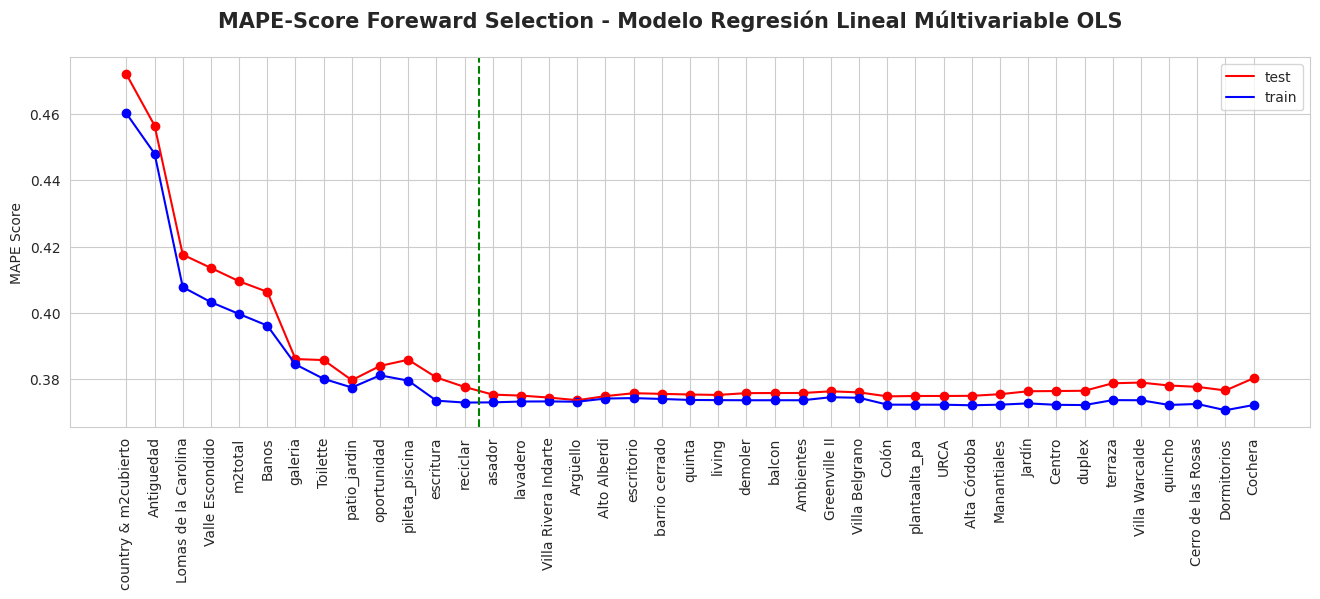

In [ ]:
x_plot=variable_agregadas_lin
y_plot_train=resultsOLS_df["MAPE (Train)"].values
y_plot_test=resultsOLS_df["MAPE (Test)"].values
fig,ax = plt.subplots()
ax.plot(x_plot,y_plot_test,color="red",label="test")
ax.scatter(x_plot,y_plot_test,color="red")
ax.plot(x_plot,y_plot_train,color="blue",label="train")
ax.scatter(x_plot,y_plot_train,color="blue")
ax.set_ylabel("MAPE Score")
ax.legend()
ax.set_xticklabels(x_plot,rotation=90);
fig.suptitle("MAPE-Score Foreward Selection - Modelo Regresión Lineal Múltivariable OLS", fontsize=15, fontweight="bold")
ax.axvline(x=12.5, color='green',linestyle='--')
fig.set_figwidth(16)
#fig.set_figheight(10)
#plt.savefig("LinMod-MAPE.eps", format="eps")
#plt.savefig("LinMod-MAPE.png", format="png")

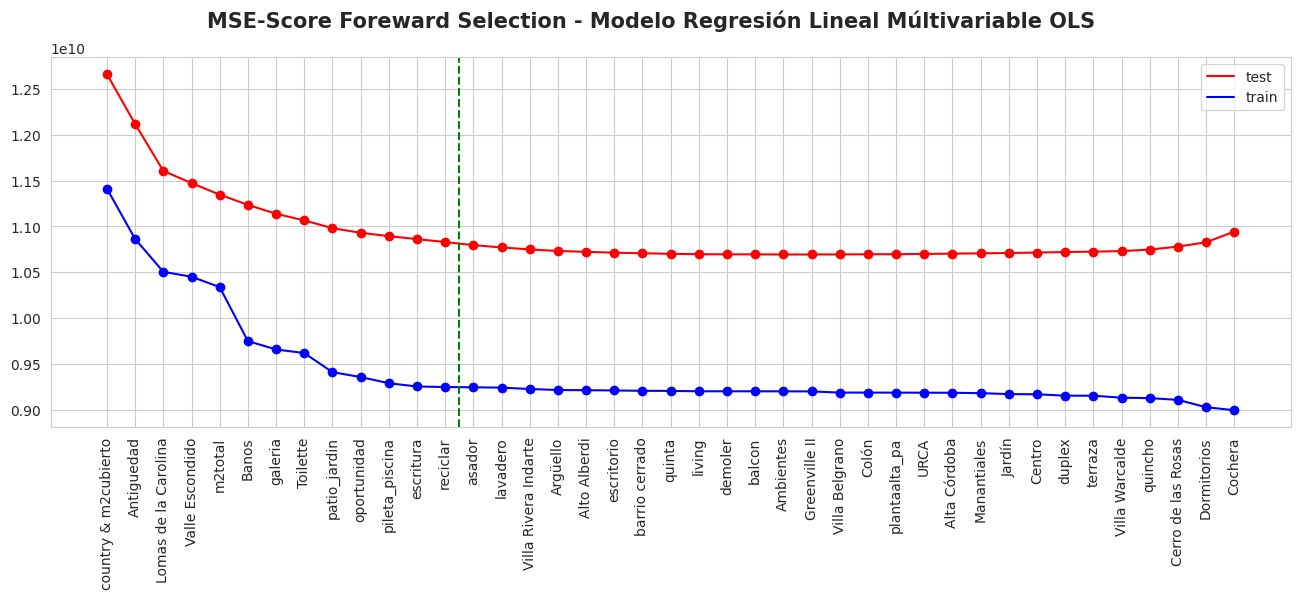

In [ ]:
x_plot=variable_agregadas_lin
y_plot_train=resultsOLS_df["MSE (Train)"].values
y_plot_test=resultsOLS_df["MSE (Test)"].values
fig,ax = plt.subplots()
ax.plot(x_plot,y_plot_test,color="red",label="test")
ax.scatter(x_plot,y_plot_test,color="red")
ax.plot(x_plot,y_plot_train,color="blue",label="train")
ax.scatter(x_plot,y_plot_train,color="blue")
ax.legend()
ax.set_xticklabels(x_plot,rotation=90);
fig.suptitle("MSE-Score Foreward Selection - Modelo Regresión Lineal Múltivariable OLS", fontsize=15, fontweight="bold")
ax.axvline(x=12.5, color='green',linestyle='--')
fig.set_figwidth(16)

#plt.savefig("LinMod-MSE.eps", format="eps")
#plt.savefig("LinMod-MSE.png", format="png")

Con los resultados anteriores, obtenemos un subconjunto de variables sobre las cuales emplear modelos siguientes

In [ ]:
print("LISTADO DE VARIABLES A UTILIZAR EN MODELO POLINOMICO OLS")
print("Cantidad de variables a utilizar:",len(resultsOLS_df['Variables Seleccionadas'][12]))
print(resultsOLS_df['Variables Seleccionadas'][12])

LISTADO DE VARIABLES A UTILIZAR EN MODELO POLINOMICO OLS
Cantidad de variables a utilizar: 14
{'reciclar', 'country', 'm2total', 'Lomas de la Carolina', 'Antiguedad', 'galeria', 'Banos', 'escritura', 'pileta_piscina', 'Toilette', 'm2cubierto', 'patio_jardin', 'oportunidad', 'Valle Escondido'}


## Regresión Polinómica (OLS)

Empleamos el subconjunto de variables de la sección anterior para incluir términos cuadráticos de dichas variables.

In [ ]:
features_regr =list({'Valle Escondido', 'm2cubierto', 'Banos', 'Toilette', 'm2total', 'Antiguedad', 'patio_jardin', 'Lomas de la Carolina', 'escritura', 'oportunidad', 'pileta_piscina', 'galeria', 'reciclar', 'country'})

print("Numero de Features =",len(features_regr))

target_regr = ['Precio']

Numero de Features = 14


In [ ]:
# Divide las variables independientes (X) y la variable dependiente (y)
X = dfLF[features_regr]
y = dfLF[target_regr]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
poly = PolynomialFeatures(degree=2)
poly.fit_transform(X_train)
features_regr_poly= poly.get_feature_names_out()

In [ ]:
X_train_poly = pd.DataFrame(data=poly.fit_transform(X_train) , columns=poly.get_feature_names_out())
X_test_poly = pd.DataFrame(data=poly.fit_transform(X_test) , columns=poly.get_feature_names_out())

In [ ]:
X_train_poly

,1,reciclar,m2total,country,Lomas de la Carolina,Antiguedad,galeria,Banos,escritura,pileta_piscina,...,m2cubierto^2,m2cubierto patio_jardin,m2cubierto oportunidad,m2cubierto Valle Escondido,patio_jardin^2,patio_jardin oportunidad,patio_jardin Valle Escondido,oportunidad^2,oportunidad Valle Escondido,Valle Escondido^2
0,1.0,0.0,444.0,0.0,0.0,60.0,0.0,2.0,1.0,0.0,...,21025.0,145.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,2189.0,0.0,0.0,30.0,0.0,3.0,0.0,1.0,...,117649.0,343.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,375.0,0.0,0.0,11.0,0.0,2.0,0.0,1.0,...,28900.0,170.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,362.0,0.0,0.0,45.0,0.0,2.0,0.0,0.0,...,57600.0,240.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,313.0,0.0,0.0,53.0,1.0,1.0,0.0,0.0,...,26569.0,163.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5559,1.0,0.0,600.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,...,67600.0,260.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5560,1.0,0.0,180.0,0.0,0.0,10.0,0.0,1.0,1.0,0.0,...,8100.0,90.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5561,1.0,0.0,312.0,0.0,0.0,26.0,0.0,2.0,0.0,1.0,...,51529.0,227.0,227.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
5562,1.0,0.0,145.0,0.0,0.0,55.0,0.0,2.0,1.0,0.0,...,21025.0,0.0,145.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
def forward_selection_olstestpol2(X_train, X_test, y_train, y_test, variables_disponibles, k):
    selected_variables = {'1',
                          'Antiguedad',
                          'Banos',
                          'Lomas de la Carolina',
                          'Toilette',
                          'Valle Escondido',
                          'country',
                          'escritura',
                          'galeria',
                          'm2cubierto',
                          'm2total',
                          'oportunidad',
                          'patio_jardin',
                          'pileta_piscina',
                          'reciclar'}  # Variables fijas desde el principio

    r2_scores_train = []
    r2_scores_test = []
    mape_scores_train = []
    mape_scores_test = []

    resultsOLS = {'Variables Seleccionadas': [],
                  'R^2 Ajustado (Train)': [],
                  'R^2 Ajustado (Test)': [],
                  'MAPE (Train)': [],
                  'MAPE (Test)': [],
                  'MSE (Train)': [],
                  'MSE (Test)': []}

    predictor_count = 0  # Inicializar el contador de predictores agregados
    kk=0
    while variables_disponibles:# and predictor_count < k:
        kk=kk+1
        best_r2_test = -np.inf
        best_variable = None

        for variable in variables_disponibles:
            variables_temp = list(selected_variables) + [variable]
            X_train_temp = X_train[variables_temp]
            X_test_temp = X_test[variables_temp]

            model = sm.OLS(y_train, X_train_temp).fit()
            y_pred_train = model.predict(X_train_temp)
            y_pred_test = model.predict(X_test_temp)

            r2_train = r2_score(y_train, y_pred_train)
            r2_test = r2_score(y_test, y_pred_test)

            mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
            mape_test = mean_absolute_percentage_error(y_test, y_pred_test)

            if r2_test > best_r2_test:
                best_r2_test = r2_test
                best_variable = variable

        if best_variable is not None:
            print(f"--------PASO {kk}----------")
            print(f"Variable agregada: {best_variable}")
            print(f"R^2 ajustado en train: {r2_train}")
            print(f"R^2 ajustado en test: {best_r2_test}")
            print(f"MAPE en train: {mape_train}")
            print(f"MAPE en test: {mape_test}\n")

            selected_variables.add(best_variable)
            variables_disponibles.remove(best_variable)
            r2_scores_train.append(r2_train)
            r2_scores_test.append(best_r2_test)
            mape_scores_train.append(mape_train)
            mape_scores_test.append(mape_test)

            # Excluir las variables ya seleccionadas de las disponibles
            variables_disponibles = [var for var in variables_disponibles if var not in selected_variables]

            X_train_temp = X_train[selected_variables]
            X_test_temp = X_test[selected_variables]
            model = sm.OLS(y_train, X_train_temp).fit()
            y_pred_train = model.predict(X_train_temp)
            y_pred_test = model.predict(X_test_temp)

            r2_train = r2_score(y_train, y_pred_train)
            r2_test = r2_score(y_test, y_pred_test)
            MSEtr = mean_squared_error(y_train, y_pred_train)
            MSEte = mean_squared_error(y_test, y_pred_test)

            # Agregar los resultados a la tabla
            resultsOLS['Variables Seleccionadas'].append(selected_variables.copy())
            resultsOLS['R^2 Ajustado (Train)'].append(r2_train)
            resultsOLS['R^2 Ajustado (Test)'].append(r2_test)
            resultsOLS['MAPE (Train)'].append(mape_train)
            resultsOLS['MAPE (Test)'].append(mape_test)
            resultsOLS['MSE (Train)'].append(MSEtr)
            resultsOLS['MSE (Test)'].append(MSEte)

            predictor_count += 1  # Incrementar el contador de predictores agregados

    resultsOLS_df = pd.DataFrame(resultsOLS)
    return selected_variables, r2_scores_train, r2_scores_test, mape_scores_train, mape_scores_test, resultsOLS_df

In [ ]:
X_train_poly = X_train_poly.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test_poly = X_test_poly.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [ ]:
selected_vars, r2_train, r2_test, mape_train, mape_test, resultsOLSpol2_df = forward_selection_olstestpol2(
    X_train=X_train_poly,
    X_test=X_test_poly,
    y_train=y_train,
    y_test=y_test,
    variables_disponibles=X_train_poly.columns.tolist(),
    k=20
)

--------PASO 1----------
Variable agregada: m2total Lomas de la Carolina
R^2 ajustado en train: 0.7232171592933396
R^2 ajustado en test: 0.6520014952365372
MAPE en train: 0.37734375811238097
MAPE en test: 0.3755822123230814

--------PASO 2----------
Variable agregada: m2total^2
R^2 ajustado en train: 0.7269250452335589
R^2 ajustado en test: 0.6597021117600577
MAPE en train: 0.3769088491155236
MAPE en test: 0.37477070159151915

--------PASO 3----------
Variable agregada: Lomas de la Carolina patio_jardin
R^2 ajustado en train: 0.7344812684169222
R^2 ajustado en test: 0.6657433269563138
MAPE en train: 0.36583667741860276
MAPE en test: 0.3645076125609297

--------PASO 4----------
Variable agregada: country m2cubierto
R^2 ajustado en train: 0.7356375139972446
R^2 ajustado en test: 0.6710265189388911
MAPE en train: 0.3658969517589227
MAPE en test: 0.36431702640110597

--------PASO 5----------
Variable agregada: pileta_piscina m2cubierto
R^2 ajustado en train: 0.7377220264457234
R^2 ajustado

In [ ]:
resultsOLSpol2_df

,Variables Seleccionadas,R^2 Ajustado (Train),R^2 Ajustado (Test),MAPE (Train),MAPE (Test),MSE (Train),MSE (Test)
0,"{country, m2total, Antiguedad, 1, escritura, g...",0.726925,0.652001,0.377344,0.375582,9.121925e+09,1.045797e+10
1,"{country, m2total, Antiguedad, 1, escritura, g...",0.734481,0.659702,0.376909,0.374771,8.869514e+09,1.022655e+10
2,"{country, m2total, Antiguedad, 1, escritura, g...",0.735638,0.665743,0.365837,0.364508,8.830890e+09,1.004500e+10
3,"{country, m2total, Antiguedad, 1, escritura, g...",0.737722,0.671027,0.365897,0.364317,8.761258e+09,9.886235e+09
4,"{country, m2total, Antiguedad, 1, escritura, g...",0.740151,0.674379,0.358896,0.358328,8.680135e+09,9.785501e+09
...,...,...,...,...,...,...,...
100,"{pileta_piscina Toilette, m2cubierto oportunid...",0.789876,0.664783,0.327700,0.348902,7.019080e+09,1.007387e+10
101,"{pileta_piscina Toilette, m2cubierto oportunid...",0.796589,0.663540,0.327113,0.348693,6.794824e+09,1.011122e+10
102,"{pileta_piscina Toilette, m2cubierto oportunid...",0.806489,0.659593,0.325295,0.346689,6.464136e+09,1.022982e+10
103,"{pileta_piscina Toilette, m2cubierto oportunid...",0.818537,0.659583,0.325210,0.346643,6.061690e+09,1.023013e+10


In [ ]:
############## PLOTS #######################################
variable_agregadas_pol=[]
for i in range(len(resultsOLSpol2_df["Variables Seleccionadas"].values)-1):
    #print(i)
    variable_agregada_set=resultsOLSpol2_df["Variables Seleccionadas"].values[i+1] - resultsOLSpol2_df["Variables Seleccionadas"].values[i]
    print(variable_agregada_set)
    variable_agregadas_pol.append(list(variable_agregada_set)[0])

variable_agregadas_pol.insert(0,"Lomas de la Carolina m2total")
len(variable_agregadas_pol)

{'m2total^2'}
{'Lomas de la Carolina patio_jardin'}
{'country m2cubierto'}
{'pileta_piscina m2cubierto'}
{'Toilette m2cubierto'}
{'Antiguedad m2cubierto'}
{'m2cubierto Valle Escondido'}
{'Lomas de la Carolina Antiguedad'}
{'Banos oportunidad'}
{'Banos Toilette'}
{'Lomas de la Carolina escritura'}
{'Banos^2'}
{'Banos patio_jardin'}
{'Toilette Valle Escondido'}
{'country galeria'}
{'Antiguedad galeria'}
{'pileta_piscina Valle Escondido'}
{'reciclar Banos'}
{'Antiguedad pileta_piscina'}
{'pileta_piscina Toilette'}
{'country oportunidad'}
{'reciclar Antiguedad'}
{'m2total m2cubierto'}
{'pileta_piscina oportunidad'}
{'reciclar pileta_piscina'}
{'m2total galeria'}
{'Lomas de la Carolina Toilette'}
{'patio_jardin Valle Escondido'}
{'reciclar escritura'}
{'reciclar galeria'}
{'oportunidad Valle Escondido'}
{'galeria pileta_piscina'}
{'Banos pileta_piscina'}
{'country Valle Escondido'}
{'country pileta_piscina'}
{'m2total Valle Escondido'}
{'pileta_piscina patio_jardin'}
{'Toilette patio_jardin

105

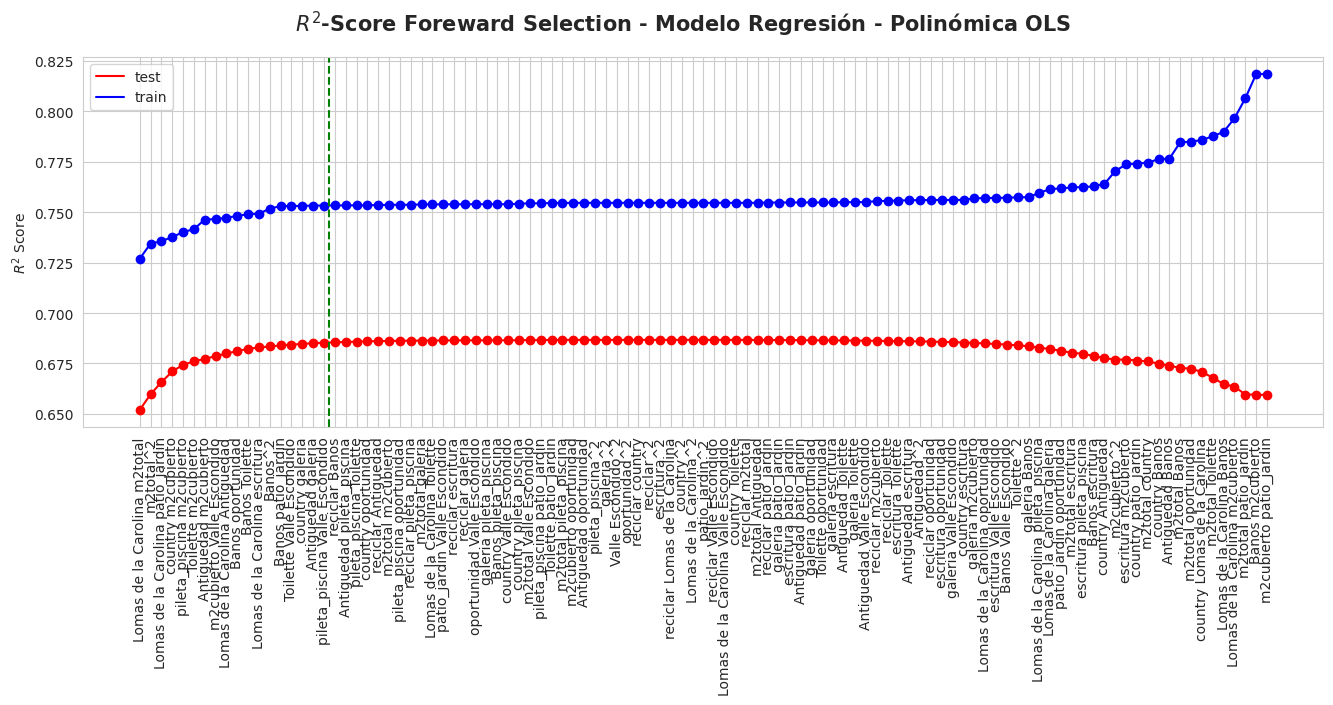

In [ ]:
x_plot=variable_agregadas_pol #[:45] # esto ultimo comentado es por si se quiere solo plotear los primeros 45 elementos en vez de todos
y_plot_train=resultsOLSpol2_df["R^2 Ajustado (Train)"].values #[:45]
y_plot_test=resultsOLSpol2_df["R^2 Ajustado (Test)"].values #[:45]
fig,ax = plt.subplots()
ax.plot(x_plot,y_plot_test,color="red",label="test")
ax.scatter(x_plot,y_plot_test,color="red")
ax.plot(x_plot,y_plot_train,color="blue",label="train")
ax.scatter(x_plot,y_plot_train,color="blue")
ax.set_ylabel("$R^2$ Score")
ax.legend()
ax.set_xticklabels(x_plot,rotation=90);
fig.suptitle("$R^2$-Score Foreward Selection - Modelo Regresión - Polinómica OLS", fontsize=15, fontweight="bold")
fig.set_figwidth(16)
ax.axvline(x=17.5, color='green',linestyle='--')
#plt.savefig("PolMod-R2.eps", format="eps")
#plt.savefig("PolMod-R2.png", format="png")


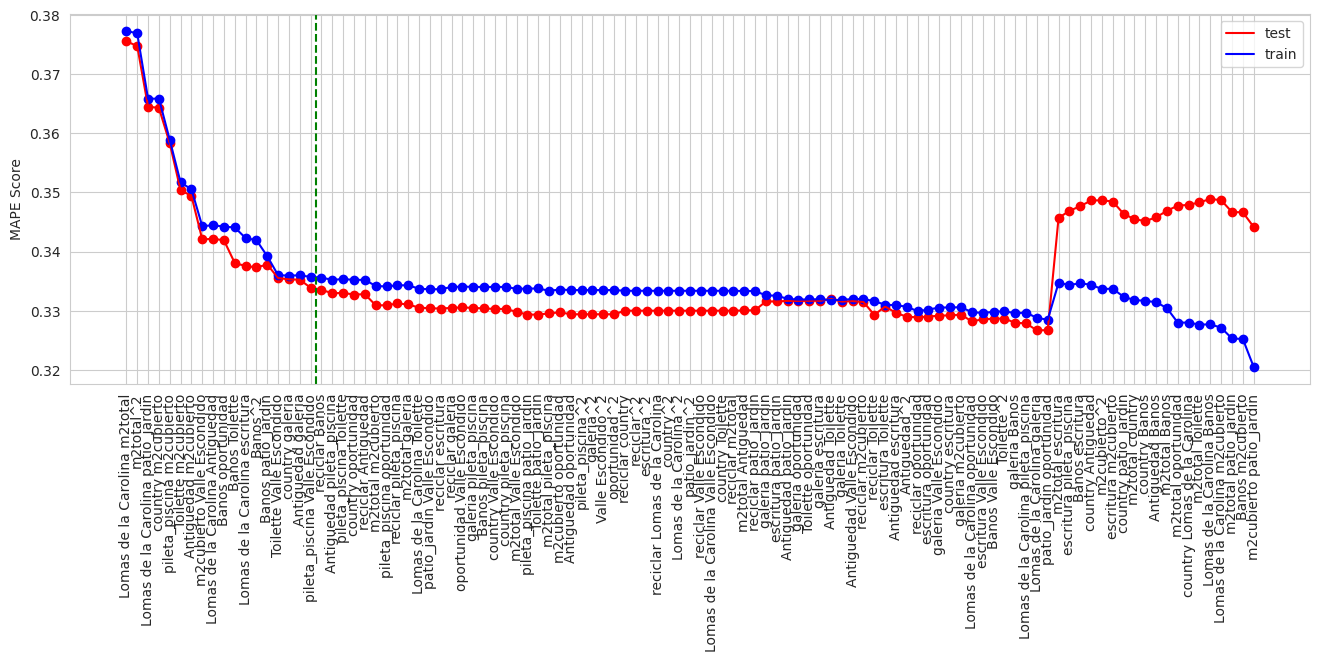

In [ ]:
x_plot=variable_agregadas_pol
y_plot_train=resultsOLSpol2_df["MAPE (Train)"].values
y_plot_test=resultsOLSpol2_df["MAPE (Test)"].values
fig,ax = plt.subplots()
ax.plot(x_plot,y_plot_test,color="red",label="test")
ax.scatter(x_plot,y_plot_test,color="red")
ax.plot(x_plot,y_plot_train,color="blue",label="train")
ax.scatter(x_plot,y_plot_train,color="blue")
ax.set_ylabel("MAPE Score")
ax.legend()
ax.axvline(x=17.5, color='green',linestyle='--')
ax.set_xticklabels(x_plot,rotation=90);
fig.set_figwidth(16)
#plt.savefig("PolMod-MAPE.png", format="png")


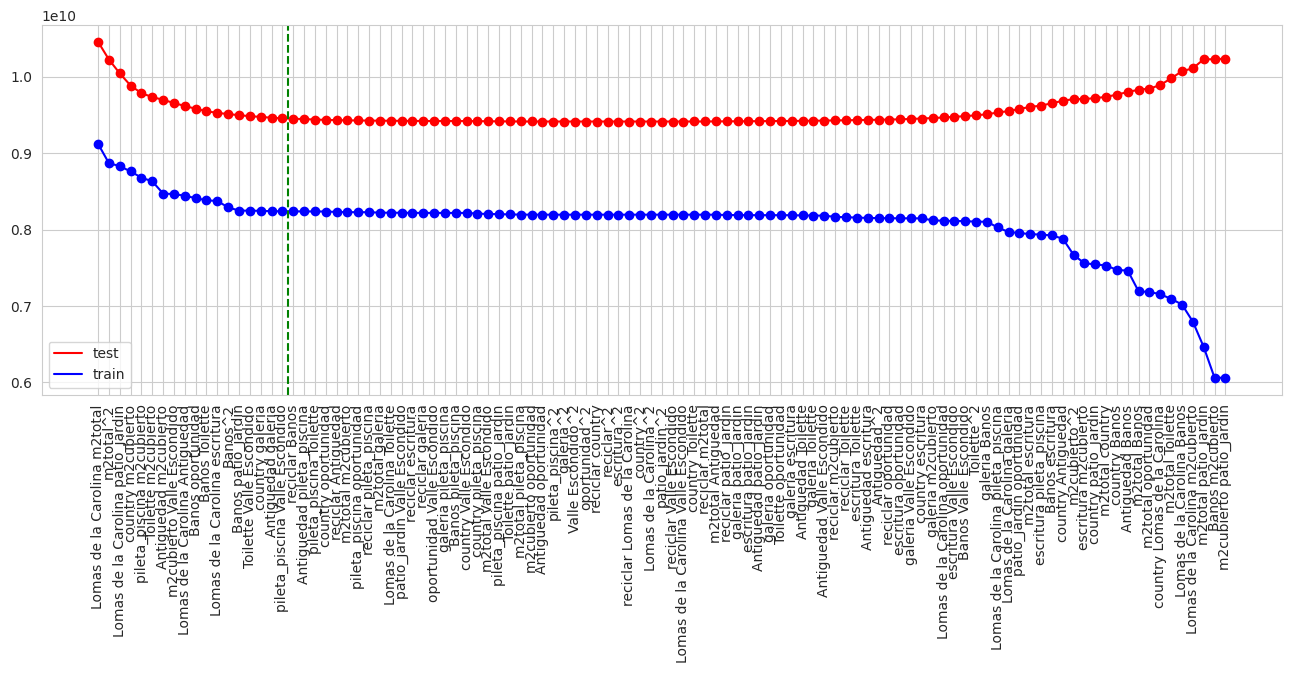

In [ ]:
x_plot=variable_agregadas_pol
y_plot_train=resultsOLSpol2_df["MSE (Train)"].values
y_plot_test=resultsOLSpol2_df["MSE (Test)"].values
fig,ax = plt.subplots()
ax.plot(x_plot,y_plot_test,color="red",label="test")
ax.scatter(x_plot,y_plot_test,color="red")
ax.plot(x_plot,y_plot_train,color="blue",label="train")
ax.scatter(x_plot,y_plot_train,color="blue")
ax.legend()
ax.axvline(x=17.5, color='green',linestyle='--')
ax.set_xticklabels(x_plot,rotation=90);
fig.set_figwidth(16)
#plt.savefig("PolMod-MSE.png", format="png")

In [ ]:
resultsOLSpol2_df['Variables Seleccionadas'][17]

{'1',
 'Antiguedad',
 'Antiguedad galeria',
 'Antiguedad m2cubierto',
 'Banos',
 'Banos Toilette',
 'Banos oportunidad',
 'Banos patio_jardin',
 'Banos^2',
 'Lomas de la Carolina',
 'Lomas de la Carolina Antiguedad',
 'Lomas de la Carolina escritura',
 'Lomas de la Carolina patio_jardin',
 'Toilette',
 'Toilette Valle Escondido',
 'Toilette m2cubierto',
 'Valle Escondido',
 'country',
 'country galeria',
 'country m2cubierto',
 'escritura',
 'galeria',
 'm2cubierto',
 'm2cubierto Valle Escondido',
 'm2total',
 'm2total Lomas de la Carolina',
 'm2total^2',
 'oportunidad',
 'patio_jardin',
 'pileta_piscina',
 'pileta_piscina Valle Escondido',
 'pileta_piscina m2cubierto',
 'reciclar'}

In [ ]:
print("LISTADO DE VARIABLES A UTILIZAR EN MODELO CON REGULARIZACIÓN")
print("Cantidad de variables a utilizar:",len(resultsOLSpol2_df['Variables Seleccionadas'][17]))
print(resultsOLSpol2_df['Variables Seleccionadas'][17])

LISTADO DE VARIABLES A UTILIZAR EN MODELO CON REGULARIZACIÓN
Cantidad de variables a utilizar: 33
{'Antiguedad m2cubierto', '1', 'escritura', 'galeria', 'm2total^2', 'Lomas de la Carolina patio_jardin', 'm2total Lomas de la Carolina', 'pileta_piscina m2cubierto', 'reciclar', 'Lomas de la Carolina', 'Banos Toilette', 'Banos', 'Toilette', 'Lomas de la Carolina Antiguedad', 'Lomas de la Carolina escritura', 'm2cubierto Valle Escondido', 'country', 'm2total', 'Toilette Valle Escondido', 'Antiguedad', 'Antiguedad galeria', 'pileta_piscina Valle Escondido', 'pileta_piscina', 'patio_jardin', 'Valle Escondido', 'country m2cubierto', 'Banos^2', 'country galeria', 'Toilette m2cubierto', 'Banos patio_jardin', 'Banos oportunidad', 'm2cubierto', 'oportunidad'}


## Regresión Polinómica con Regularización Ridge

In [ ]:
features_regr=list({'Valle Escondido', 'm2cubierto', 'Banos', 'Toilette', 'm2total', 'Antiguedad', 'patio_jardin', 'Lomas de la Carolina', 'escritura', 'oportunidad', 'pileta_piscina', 'galeria', 'reciclar', 'country'})



features_regr_polynomic=list({'Antiguedad m2cubierto', '1', 'escritura', 'galeria', 'm2total^2', 'Lomas de la Carolina patio_jardin', 'm2total Lomas de la Carolina', 'pileta_piscina m2cubierto', 'reciclar', 'Lomas de la Carolina', 'Banos Toilette', 'Banos', 'Toilette', 'Lomas de la Carolina Antiguedad', 'Lomas de la Carolina escritura', 'm2cubierto Valle Escondido', 'country', 'm2total', 'Toilette Valle Escondido', 'Antiguedad', 'Antiguedad galeria', 'pileta_piscina Valle Escondido', 'pileta_piscina', 'patio_jardin', 'Valle Escondido', 'country m2cubierto', 'Banos^2', 'country galeria', 'Toilette m2cubierto', 'Banos patio_jardin', 'Banos oportunidad', 'm2cubierto', 'oportunidad'})

print("Numero de Features =",len(features_regr))

target_regr = ['Precio']

Numero de Features = 14


In [ ]:
# Divide las variables independientes (X) y la variable dependiente (y)
X = dfLF[features_regr]
y = dfLF[target_regr]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
poly = PolynomialFeatures(degree=2)
poly.fit_transform(X_train)
features_regr_poly= poly.get_feature_names_out()

In [ ]:
X_train_poly = pd.DataFrame(data=poly.fit_transform(X_train) , columns=poly.get_feature_names_out())
X_test_poly = pd.DataFrame(data=poly.fit_transform(X_test) , columns=poly.get_feature_names_out())

In [ ]:
#Nos restringimos alas variables que polinomicas de interés
X_train_poly = X_train_poly[features_regr_polynomic]
X_test_poly = X_test_poly[features_regr_polynomic]

In [ ]:
modelo_polinom_ridge=make_pipeline(linear_model.Ridge())
modelo_polinom_ridge.get_params()

{'memory': None,
 'steps': [('ridge', Ridge())],
 'verbose': False,
 'ridge': Ridge(),
 'ridge__alpha': 1.0,
 'ridge__copy_X': True,
 'ridge__fit_intercept': True,
 'ridge__max_iter': None,
 'ridge__positive': False,
 'ridge__random_state': None,
 'ridge__solver': 'auto',
 'ridge__tol': 0.0001}

In [ ]:
#Defino pipeline

alphas = [2**i for i in range(-13,13) ]
parameters = {'ridge__alpha': alphas}


modelo_polinom_ridge=make_pipeline(linear_model.Ridge())
GS_modelo_polinom_ridge = GridSearchCV(modelo_polinom_ridge, parameters, scoring = "neg_mean_absolute_percentage_error")

In [ ]:
GS_modelo_polinom_ridge.fit(X_train_poly, y_train)
GS_modelo_polinom_ridge.best_params_, GS_modelo_polinom_ridge.best_score_

({'ridge__alpha': 128}, -0.34077282068741244)

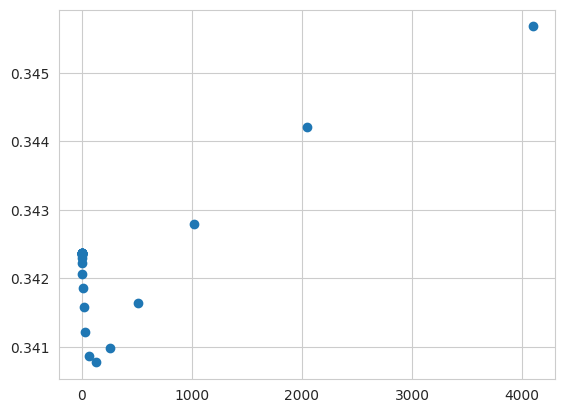

In [ ]:
plt.scatter(alphas,-GS_modelo_polinom_ridge.cv_results_["mean_test_score"])
#plt.xlim(50,120)

In [ ]:
modelo_ridge_opt = GS_modelo_polinom_ridge.best_estimator_
print("TRAIN")
scores_models(y_real=y_train,y_predicted=modelo_ridge_opt.predict(X_train_poly))
print("TEST")
scores_models(y_real=y_test,y_predicted=modelo_ridge_opt.predict(X_test_poly))

TRAIN
Score MSE  : 8385586057.86376
Score RMSE : 91572.84564
Score MAPE : 0.33462
R^2-score  : 0.74897
TEST
Score MSE  : 9918129121.46137
Score RMSE : 99589.80430
Score MAPE : 0.33662
R^2-score  : 0.66997


---

In [ ]:
# Residuos
Residuos_ridge=y_test - modelo_ridge_opt.predict(X_test_poly)
#Residuos_lasso=y_test - modelo_lasso_opt.predict(X_test)
#Residuos_elnet=y_test - modelo_elnet_opt.predict(X_test)
#print(Residuos.mean())
#fig,ax= plt.subplots()
#ax.hist(Residuos_ridge,bins=150,alpha=0.5,color="blue",label="Ridge")
#ax.hist(Residuos_lasso,bins=150,alpha=0.5,color="yellow",label="Lasso")
#ax.hist(Residuos_elnet,bins=150,alpha=0.5,color="pink",label="Elastic Net")
#fig.suptitle("Distribución Estadística de los Residuos - Modelos Con Regularización", fontsize=16,weight="bold")
#ax.legend(fontsize=24)
#ax.set_xlim(-0.3e6,0.4e6)
#fig.set_figwidth(16)
#fig.set_figheight(10)
#plt.savefig("Residuos-Ridge.png", format="png")


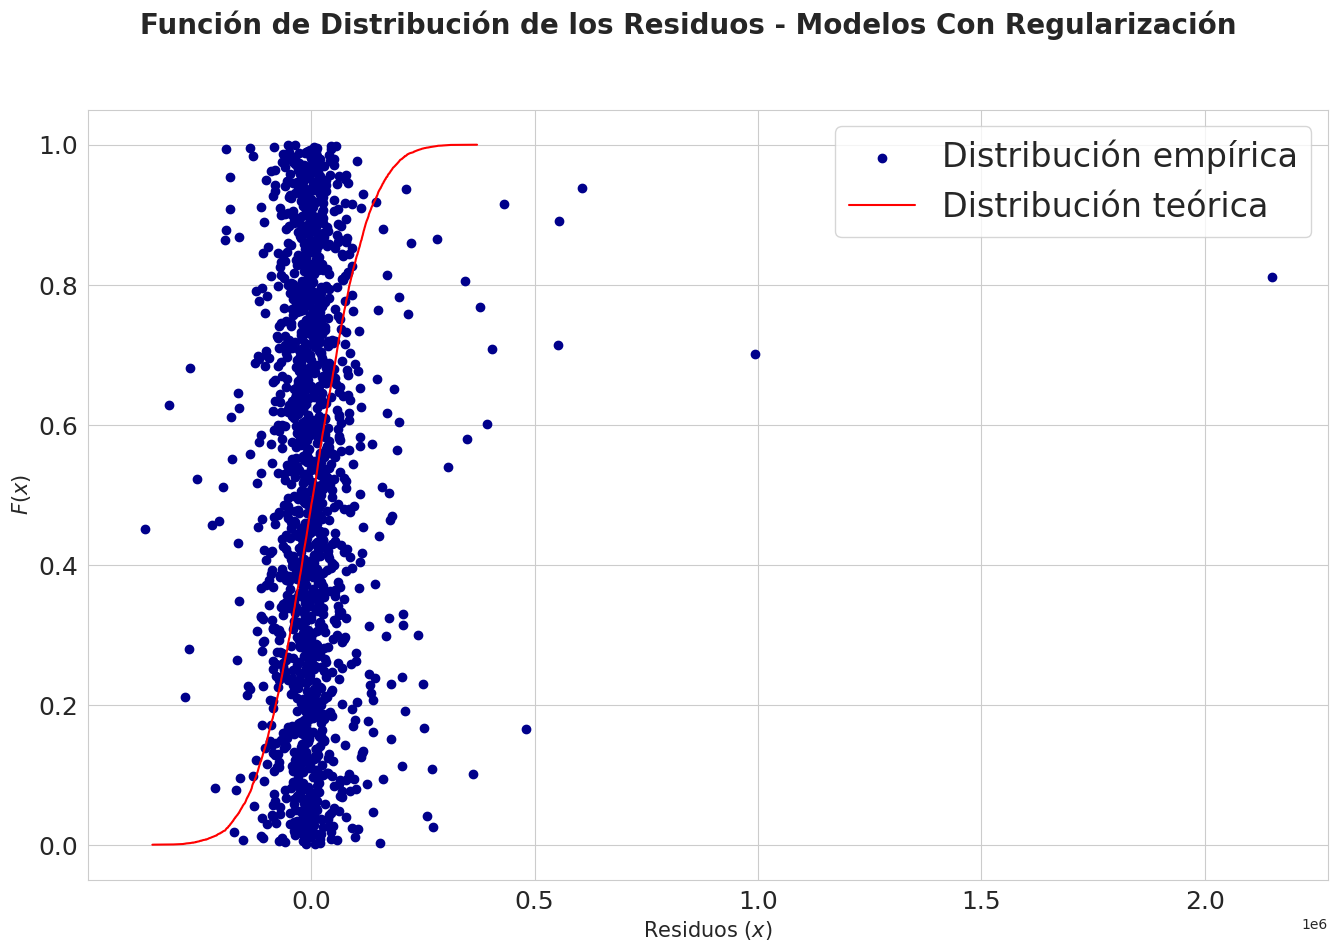

In [ ]:
# Armamos la función de distribución observada de nuestros residuos para analizar su normalidad
x = np.sort(Residuos_ridge)              # ordenamos los residuos
n = x.size                         # tamaño total de la muestra
y = np.arange(1, n+1) / n          # calculamos las probabilidades acumuladas por cada valor observado en orden

# Luego obtenemos la función de distribución teórica de una normal
Residuos_teoricos = np.random.normal(loc = np.mean(Residuos_ridge),   # obtenemos una muestra aleatoria proveniente de una
                    scale = np.std(Residuos_ridge), size = 10000)     # distribución normal con la media y desv.est. de nuestros residuos
x_teor = np.sort(Residuos_teoricos)       # ordenamos la muestra aleatoria
n_teor = x_teor.size                      # guardamos el tamaño de esta muestra
y_teor = np.arange(1, n_teor+1) / n_teor  # calculamos las probabilidades acumuladas por sus valores

# Por último, superponemos ambas distribuciones en un mismo gráfico
fig, ax = plt.subplots()
#fig.suptitle("Distribución empírica vs. teórica", fontsize = 18, fontweight = "bold")
ax.scatter(x, y, color = "darkblue", label = "Distribución empírica")
ax.plot(x_teor, y_teor, color = "red", label = "Distribución teórica")
ax.set_xlabel("Residuos ($x$)", fontsize = 15)
ax.set_ylabel("$F(x)$", fontsize = 15)
ax.tick_params(labelsize = 18)
ax.legend(fontsize=24)
#plt.subplots_adjust(top = 0.85)
fig.suptitle("Función de Distribución de los Residuos - Modelos Con Regularización", fontsize=20,weight="bold")
fig.set_figwidth(16)
fig.set_figheight(10)
plt.show()
#plt.savefig("/content/drive/MyDrive/Colab Notebooks/DistribucionEmpirica-Ridge.png", format="png")

---

## Regresión Polinómica con Regularización Lasso

In [ ]:
features_regr=list({'Valle Escondido', 'm2cubierto', 'Banos', 'Toilette', 'm2total', 'Antiguedad', 'patio_jardin', 'Lomas de la Carolina', 'escritura', 'oportunidad', 'pileta_piscina', 'galeria', 'reciclar', 'country'})



features_regr_polynomic=list({'Antiguedad m2cubierto', '1', 'escritura', 'galeria', 'm2total^2', 'Lomas de la Carolina patio_jardin', 'm2total Lomas de la Carolina', 'pileta_piscina m2cubierto', 'reciclar', 'Lomas de la Carolina', 'Banos Toilette', 'Banos', 'Toilette', 'Lomas de la Carolina Antiguedad', 'Lomas de la Carolina escritura', 'm2cubierto Valle Escondido', 'country', 'm2total', 'Toilette Valle Escondido', 'Antiguedad', 'Antiguedad galeria', 'pileta_piscina Valle Escondido', 'pileta_piscina', 'patio_jardin', 'Valle Escondido', 'country m2cubierto', 'Banos^2', 'country galeria', 'Toilette m2cubierto', 'Banos patio_jardin', 'Banos oportunidad', 'm2cubierto', 'oportunidad'})


print("Numero de Features =",len(features_regr))

target_regr = ['Precio']

Numero de Features = 14


In [ ]:
# Divide las variables independientes (X) y la variable dependiente (y)
X = dfLF[features_regr]
y = dfLF[target_regr]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
poly = PolynomialFeatures(degree=2)
poly.fit_transform(X_train)
features_regr_poly= poly.get_feature_names_out()

In [ ]:
X_train_poly = pd.DataFrame(data=poly.fit_transform(X_train) , columns=poly.get_feature_names_out())
X_test_poly = pd.DataFrame(data=poly.fit_transform(X_test) , columns=poly.get_feature_names_out())

In [ ]:
#Nos restringimos alas variables que polinomicas de interés
X_train_poly = X_train_poly[features_regr_polynomic]
X_test_poly = X_test_poly[features_regr_polynomic]

In [ ]:
modelo_polinom_lasso=make_pipeline(linear_model.Lasso())
modelo_polinom_lasso.get_params()

{'memory': None,
 'steps': [('lasso', Lasso())],
 'verbose': False,
 'lasso': Lasso(),
 'lasso__alpha': 1.0,
 'lasso__copy_X': True,
 'lasso__fit_intercept': True,
 'lasso__max_iter': 1000,
 'lasso__positive': False,
 'lasso__precompute': False,
 'lasso__random_state': None,
 'lasso__selection': 'cyclic',
 'lasso__tol': 0.0001,
 'lasso__warm_start': False}

In [ ]:
#Defino pipeline

alphas = [2**i for i in range(-13,13) ]
parameters = {'lasso__alpha': alphas}


modelo_polinom_lasso=make_pipeline(linear_model.Lasso())
GS_modelo_polinom_lasso = GridSearchCV(modelo_polinom_lasso, parameters, scoring = "neg_mean_absolute_percentage_error")

In [ ]:
GS_modelo_polinom_lasso.fit(X_train_poly, y_train)
GS_modelo_polinom_lasso.best_params_, GS_modelo_polinom_lasso.best_score_

({'lasso__alpha': 128}, -0.3415995213475213)

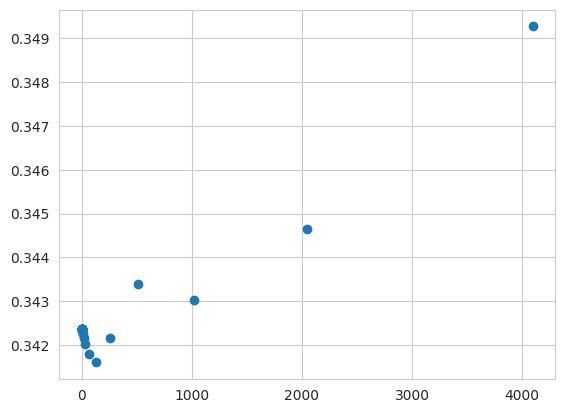

In [ ]:
plt.scatter(alphas,-GS_modelo_polinom_lasso.cv_results_["mean_test_score"])

In [ ]:
modelo_lasso_opt = GS_modelo_polinom_lasso.best_estimator_
print("TRAIN")
scores_models(y_real=y_train,y_predicted=modelo_lasso_opt.predict(X_train_poly))
print("TEST")
scores_models(y_real=y_test,y_predicted=modelo_lasso_opt.predict(X_test_poly))

TRAIN
Score MSE  : 8293852189.49122
Score RMSE : 91070.58905
Score MAPE : 0.33485
R^2-score  : 0.75171
TEST
Score MSE  : 9707541476.03175
Score RMSE : 98526.85662
Score MAPE : 0.33561
R^2-score  : 0.67697


In [ ]:
modelo_lasso_opt.predict(X_test_poly).reshape(-1,1)

array([[148425.93246188],
       [835969.33091251],
       [133649.32250403],
       ...,
       [234330.01930194],
       [206169.7483233 ],
       [166979.49449004]])

In [ ]:
y_test.shape

(1392, 1)

In [ ]:
Residuos_lasso=y_test - modelo_lasso_opt.predict(X_test_poly).reshape(-1,1)

## Regresión Polinómica con Regularización Elastic Net

In [ ]:
features_regr=list({'Valle Escondido', 'm2cubierto', 'Banos', 'Toilette', 'm2total', 'Antiguedad', 'patio_jardin', 'Lomas de la Carolina', 'escritura', 'oportunidad', 'pileta_piscina', 'galeria', 'reciclar', 'country'})



features_regr_polynomic=list({'Antiguedad m2cubierto', '1', 'escritura', 'galeria', 'm2total^2', 'Lomas de la Carolina patio_jardin', 'm2total Lomas de la Carolina', 'pileta_piscina m2cubierto', 'reciclar', 'Lomas de la Carolina', 'Banos Toilette', 'Banos', 'Toilette', 'Lomas de la Carolina Antiguedad', 'Lomas de la Carolina escritura', 'm2cubierto Valle Escondido', 'country', 'm2total', 'Toilette Valle Escondido', 'Antiguedad', 'Antiguedad galeria', 'pileta_piscina Valle Escondido', 'pileta_piscina', 'patio_jardin', 'Valle Escondido', 'country m2cubierto', 'Banos^2', 'country galeria', 'Toilette m2cubierto', 'Banos patio_jardin', 'Banos oportunidad', 'm2cubierto', 'oportunidad'})

print("Numero de Features =",len(features_regr))

target_regr = ['Precio']

Numero de Features = 14


In [ ]:
# Divide las variables independientes (X) y la variable dependiente (y)
X = dfLF[features_regr]
y = dfLF[target_regr]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
poly = PolynomialFeatures(degree=2)
poly.fit_transform(X_train)
features_regr_poly= poly.get_feature_names_out()

In [ ]:
X_train_poly = pd.DataFrame(data=poly.fit_transform(X_train) , columns=poly.get_feature_names_out())
X_test_poly = pd.DataFrame(data=poly.fit_transform(X_test) , columns=poly.get_feature_names_out())

In [ ]:
#Nos restringimos alas variables que polinomicas de interés
X_train_poly = X_train_poly[features_regr_polynomic]
X_test_poly = X_test_poly[features_regr_polynomic]

In [ ]:
modelo_polinom_elnet=make_pipeline(linear_model.ElasticNet())
modelo_polinom_elnet.get_params()

{'memory': None,
 'steps': [('elasticnet', ElasticNet())],
 'verbose': False,
 'elasticnet': ElasticNet(),
 'elasticnet__alpha': 1.0,
 'elasticnet__copy_X': True,
 'elasticnet__fit_intercept': True,
 'elasticnet__l1_ratio': 0.5,
 'elasticnet__max_iter': 1000,
 'elasticnet__positive': False,
 'elasticnet__precompute': False,
 'elasticnet__random_state': None,
 'elasticnet__selection': 'cyclic',
 'elasticnet__tol': 0.0001,
 'elasticnet__warm_start': False}

In [ ]:
#Defino pipeline

alphas = [2**i for i in range(-13,13) ]
parameters = {'elasticnet__alpha': alphas,'elasticnet__l1_ratio': alphas }


modelo_polinom_elnet=make_pipeline(linear_model.ElasticNet())
GS_modelo_polinom_elnet = GridSearchCV(modelo_polinom_elnet, parameters, scoring = "neg_mean_absolute_percentage_error")

In [ ]:
GS_modelo_polinom_elnet.fit(X_train_poly, y_train)
GS_modelo_polinom_elnet.best_params_, GS_modelo_polinom_elnet.best_score_

({'elasticnet__alpha': 0.03125, 'elasticnet__l1_ratio': 0.25},
 -0.3407639143843655)

In [ ]:
modelo_elnet_opt = GS_modelo_polinom_elnet.best_estimator_
print("TRAIN")
scores_models(y_real=y_train,y_predicted=modelo_elnet_opt.predict(X_train_poly))
print("TEST")
scores_models(y_real=y_test,y_predicted=modelo_elnet_opt.predict(X_test_poly))

TRAIN
Score MSE  : 8386230843.53632
Score RMSE : 91576.36618
Score MAPE : 0.33463
R^2-score  : 0.74895
TEST
Score MSE  : 9918804992.59936
Score RMSE : 99593.19752
Score MAPE : 0.33664
R^2-score  : 0.66994


In [ ]:
Residuos_elnet=y_test - modelo_elnet_opt.predict(X_test_poly).reshape(-1,1)

---

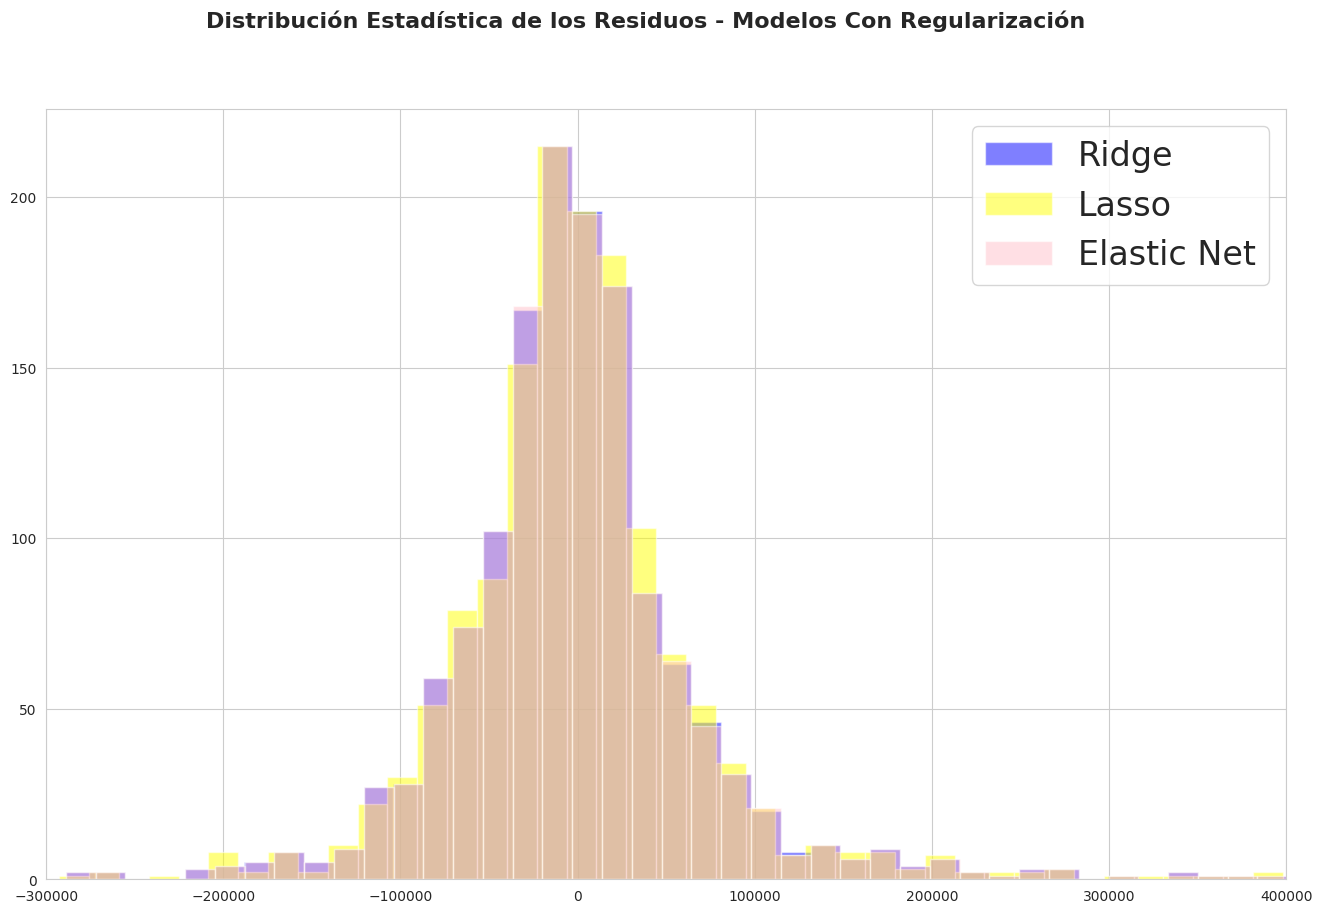

In [ ]:
# Histograma del Error
#Residuos_ridge=y_test - modelo_ridge_opt.predict(X_test_poly)
#Residuos_lasso=y_test - modelo_lasso_opt.predict(X_test_poly)
#Residuos_elnet=y_test - modelo_elnet_opt.predict(X_test_poly)
#print(Residuos.mean())
fig,ax= plt.subplots()
ax.hist(Residuos_ridge,bins=150,alpha=0.5,color="blue",label="Ridge")
ax.hist(Residuos_lasso,bins=150,alpha=0.5,color="yellow",label="Lasso")
ax.hist(Residuos_elnet,bins=150,alpha=0.5,color="pink",label="Elastic Net")
fig.suptitle("Distribución Estadística de los Residuos - Modelos Con Regularización", fontsize=16,weight="bold")
ax.legend(fontsize=24)
ax.set_xlim(-0.3e6,0.4e6)
fig.set_figwidth(16)
fig.set_figheight(10)
#plt.savefig("/content/drive/MyDrive/Colab Notebooks/Residuos-Ridge.png", format="png")

---

## MODELO DE RED NEURONALES




<FONT COLOR="#ff0000"> Nota: GridSearchCV tarda aproximadamente 30 minutos en correr en colab... 15 minutos o menos en Local en la computadora.

(Las CPU de Google no son las mejores)
</FONT>




In [ ]:
# Modelado Red Neuronal
# ==============================================================================
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV
import multiprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')


In [ ]:
dfLF.columns

Index(['Precio', 'm2total', 'm2cubierto', 'Banos', 'Dormitorios', 'Ambientes',
       'Antiguedad', 'Cochera', 'Toilette', 'Villa Belgrano', 'Argüello',
       'Cerro de las Rosas', 'URCA', 'Valle Escondido', 'Alta Córdoba',
       'Jardín', 'Alto Alberdi', 'Manantiales', 'Villa Rivera Indarte',
       'Greenville II', 'Villa Warcalde', 'Colón', 'Lomas de la Carolina',
       'Centro', 'country', 'living', 'duplex', 'quincho', 'escritura',
       'quinta', 'terraza', 'escritorio', 'lavadero', 'asador', 'galeria',
       'balcon', 'demoler', 'reciclar', 'barrio cerrado', 'oportunidad',
       'pileta_piscina', 'patio_jardin', 'plantaalta_pa'],
      dtype='object')

In [ ]:
#features_regr =  X_train.columns.tolist()
features_regr=['m2total', 'm2cubierto', 'Banos', 'Dormitorios',
       'Antiguedad', 'Cochera', 'Toilette', 'Villa Belgrano', 'Argüello',
       'Cerro de las Rosas', 'URCA', 'Valle Escondido', 'Alta Córdoba',
       'Jardín', 'Alto Alberdi', 'Manantiales', 'Villa Rivera Indarte',
       'Greenville II', 'Villa Warcalde', 'Colón', 'Lomas de la Carolina',
       'Centro', 'country', 'living', 'duplex', 'quincho', 'escritura',
       'quinta', 'terraza', 'escritorio', 'lavadero', 'asador', 'galeria',
       'balcon', 'demoler', 'reciclar', 'barrio cerrado', 'oportunidad',
       'pileta_piscina', 'patio_jardin', 'plantaalta_pa']
# features_regr =  ['m2total', 'm2cubierto', 'Banos', 'Dormitorios',
#        'Antiguedad', 'Cochera', 'Toilette', 'Villa Belgrano', 'Argüello', 'Cerro de las Rosas',
#        'URCA', 'Valle Escondido', 'Alta Córdoba', 'Jardín', 'Alto Alberdi',
#        'Manantiales', 'Villa Rivera Indarte', 'Greenville II',
#        'Villa Warcalde', 'Colón', 'Lomas de la Carolina', 'Centro', 'country',
#        'living', 'duplex', 'quincho', 'escritura', 'quinta', 'terraza',
#        'escritorio', 'lavadero', 'asador', 'galeria', 'balcon', 'demoler',
#        'reciclar', 'oportunidad', 'barrio cerrado', 'pileta_piscina',
#        'patio_jardin', 'plantaalta_pa']
#print("Numero de Features =",len(features_regr))

target_regr = ['Precio']

In [ ]:
y = dfLF[target_regr]
X = dfLF[features_regr]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)   # uso la semilla 2 para obtener los mismos sets en cada modelo

In [ ]:
#X_train = X_train.reset_index(drop=True)
#X_test = X_test.reset_index(drop=True)
#y_train = y_train.reset_index(drop=True)
#y_test = y_test.reset_index(drop=True)

In [ ]:
# Creación del Pipeline Preprocesado y Modelado
numeric_cols = ['m2total', 'm2cubierto', 'Banos', 'Dormitorios', 'Antiguedad',
       'Cochera', 'Toilette']

In [ ]:
numeric_transformer = Pipeline( steps=[ ('scaler', StandardScaler()) ]  )
preprocessor_X = ColumnTransformer( transformers=[ ('numeric', numeric_transformer, numeric_cols) ],remainder='passthrough')
preprocessor_y = ColumnTransformer( transformers=[ ('numeric', numeric_transformer, ["Precio"]) ])
#preprocessor_X

In [ ]:
X_train_prep = preprocessor_X.fit_transform(X_train)
X_test_prep  = preprocessor_X.transform(X_test)
y_train_prep = preprocessor_y.fit_transform(y_train)
y_test_prep  = preprocessor_y.transform(y_test)

In [ ]:
# Se combinan los pasos de preprocesado y el modelo en un mismo pipeline
pipe = Pipeline([('preprocessing', preprocessor_X),
                 ('modelo', MLPRegressor(solver = 'lbfgs', max_iter= 1000))])

In [ ]:
pipe.get_params()

{'memory': None,
 'steps': [('preprocessing',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('numeric',
                                    Pipeline(steps=[('scaler', StandardScaler())]),
                                    ['m2total', 'm2cubierto', 'Banos',
                                     'Dormitorios', 'Antiguedad', 'Cochera',
                                     'Toilette'])])),
  ('modelo', MLPRegressor(max_iter=1000, solver='lbfgs'))],
 'verbose': False,
 'preprocessing': ColumnTransformer(remainder='passthrough',
                   transformers=[('numeric',
                                  Pipeline(steps=[('scaler', StandardScaler())]),
                                  ['m2total', 'm2cubierto', 'Banos',
                                   'Dormitorios', 'Antiguedad', 'Cochera',
                                   'Toilette'])]),
 'modelo': MLPRegressor(max_iter=1000, solver='lbfgs'),
 'preprocessing__n_jobs': None,
 'preprocessing__remainde

In [ ]:
# Espacio de búsqueda de cada hiperparámetro
# ==============================================================================

alphas = [2**i for i in range(-4,10) ]
param_distributions = {
    #'modelo__hidden_layer_sizes': [(10), (20), (10, 10)],
    'modelo__hidden_layer_sizes': [(1),(2),(2,2),(5),(5,5),(10), (20), (10, 10)],
    'modelo__alpha':np.array(alphas),
    'modelo__learning_rate_init': [0.0001,0.001, 0.01],
    'modelo__max_iter': [3000]
}

# Búsqueda por validación cruzada
# ==============================================================================
grid = RandomizedSearchCV(
        estimator  = pipe,
        param_distributions = param_distributions,
        n_iter     = 50,
        scoring    = 'neg_mean_absolute_percentage_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = 5,
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train_prep)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(10)

,param_modelo__max_iter,param_modelo__learning_rate_init,param_modelo__hidden_layer_sizes,param_modelo__alpha,mean_test_score,std_test_score,mean_train_score,std_train_score
30,3000,0.001,"(2, 2)",0.5,-1.407289,0.325251,-1.464713,0.239831
35,3000,0.0001,"(2, 2)",0.25,-1.426222,0.543514,-1.404057,0.336168
14,3000,0.01,5,0.0625,-1.490457,0.215334,-1.544380,0.074088
44,3000,0.001,"(2, 2)",512.0,-1.492388,0.508341,-1.479927,0.381679
17,3000,0.001,"(10, 10)",4.0,-1.495337,0.237329,-1.427219,0.104848
46,3000,0.01,5,4.0,-1.516051,0.291494,-1.562973,0.083885
8,3000,0.0001,"(5, 5)",512.0,-1.516421,0.334980,-1.641626,0.320505
32,3000,0.01,"(5, 5)",8.0,-1.521898,0.262364,-1.456739,0.128815
16,3000,0.0001,5,0.125,-1.538632,0.320694,-1.447584,0.066559
9,3000,0.0001,5,0.0625,-1.544463,0.255342,-1.501460,0.101975


In [ ]:
modelo_RedNeu_opt = grid.best_estimator_

In [ ]:
modelo_RedNeu_opt['modelo'].get_params()

{'activation': 'relu',
 'alpha': 0.5,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (2, 2),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 3000,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

In [ ]:
y_train_inverse_predicted = preprocessor_y.named_transformers_['numeric'].named_steps['scaler'].inverse_transform(modelo_RedNeu_opt.predict(X_train).reshape(-1,1))

y_test_inverse_predicted = preprocessor_y.named_transformers_['numeric'].named_steps['scaler'].inverse_transform(modelo_RedNeu_opt.predict(X_test).reshape(-1,1))

In [ ]:
y_test.values

In [ ]:
scores_models(y_real=y_train,y_predicted=y_train_inverse_predicted)

Score MSE  : 7704107403.48608
Score RMSE : 87773.04486
Score MAPE : 0.30
R^2-score  : 0.76937


In [ ]:
scores_models(y_real=y_test,y_predicted=y_test_inverse_predicted)

Score MSE  : 9606818433.64851
Score RMSE : 98014.37871
Score MAPE : 0.32
R^2-score  : 0.68032
